### Postwork 6: Automatización y APIs
En esta sección del proyecto detallamos de forma puntual la extracción de datos desdde la API de Spotify, a través de "Spotipy", una librería especializada. No podemos trabajar directamente con los datos en crudo, por lo que también abordaremos la limpieza e integración del dataset. Con el fin de comprobar que los datos están listos para la etapa de input, crearemos un "perfil de gustos" con los datos obtenidos en la parte final.

Spotify nos permite acceder directamente a los datos que observamos en los datasets de Kaggle desde su API "Spotipy". Al ser una paquetería demasiado específica, no se encuentra precargada, por lo que es necesario instalarla.

In [ ]:
pip install spotipy

     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 143kB 11.5MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Una vez completa la instalación, debemos colocar nuestras credenciales como forma de autenticación, tanto el client id como el client secret (que es la contraseña) deben obtenerse desde la página de Spotify para desarrolladores.
Hacemos una llamada de información simple recabando la información de un track en Spotify.

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="72654f91e8424dc8b4924dc4cdf3674a",
                                                           client_secret="968caf037e674bb0a89533fde2831f25"))
Top2020 = sp.audio_features('4T3fNx3CgwDRRYgmFCbD4J')
Top2020

[{'acousticness': 0.0984,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4T3fNx3CgwDRRYgmFCbD4J',
  'danceability': 0.442,
  'duration_ms': 229413,
  'energy': 0.585,
  'id': '4T3fNx3CgwDRRYgmFCbD4J',
  'instrumentalness': 0.391,
  'key': 0,
  'liveness': 0.14,
  'loudness': -10.332,
  'mode': 0,
  'speechiness': 0.0964,
  'tempo': 97.565,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/4T3fNx3CgwDRRYgmFCbD4J',
  'type': 'audio_features',
  'uri': 'spotify:track:4T3fNx3CgwDRRYgmFCbD4J',
  'valence': 0.116}]

In [ ]:
La consulta de datos fue exitosa, por lo que podemos observar el vector de características que consultamos, estos podrían manipularse con mayor facilidad
a través de pandas en un dataframe, por lo que importamos el mismo y transformamos los datos para averiguar si es posible obtener un dataframe con los 
datos de la API

In [ ]:
import pandas as pd
df = pd.DataFrame(Top2020)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.442,0.585,0,-10.332,0,0.0964,0.0984,0.391,0.14,0.116,97.565,audio_features,4T3fNx3CgwDRRYgmFCbD4J,spotify:track:4T3fNx3CgwDRRYgmFCbD4J,https://api.spotify.com/v1/tracks/4T3fNx3CgwDR...,https://api.spotify.com/v1/audio-analysis/4T3f...,229413,4


In [ ]:
Dado que sí podemos combinar los datos de la API con la manipulación de pandas, ahora lo que debemos hacer es recabar la información de un mayor
número de tracks y no solametne de uno, para ello podemos explotar la función sp.playlist de Spotipy, que nos permite extraer los identificadores
de todas las canciones de un playlist

In [ ]:
playlist_id='37i9dQZF1DXdJSo3JjzjFs'
results = sp.playlist(playlist_id)

In [ ]:
Una vez que tenemos los ids y las características de los tracks, debemos unir ambos dataframes y aprovechar limpiar los datos.

In [ ]:
# Creamos una lista de ids
ids=[]

for item in results['tracks']['items']:
        track = item['track']['id']
        ids.append(track)
        
song_meta={'id':[],'album':[], 'name':[], 
           'artist':[],'explicit':[],'popularity':[]}

for song_id in ids:
    # obtenemos los metadatos de la canción
    meta = sp.track(song_id)
    
    # id de la canción
    song_meta['id'].append(song_id)

    # nombre del album
    album=meta['album']['name']
    song_meta['album']+=[album]

    # nombre de la canción
    song=meta['name']
    song_meta['name']+=[song]
    
    # nombre del artista
    s = ', '
    artist=s.join([singer_name['name'] for singer_name in meta['artists']])
    song_meta['artist']+=[artist]
    
    # Variable dicotómica sobre contenido explícito en la canción
    explicit=meta['explicit']
    song_meta['explicit'].append(explicit)
    
    # extraemos la popularidad de la canción
    popularity=meta['popularity']
    song_meta['popularity'].append(popularity)

song_meta_df=pd.DataFrame.from_dict(song_meta)

# obtenemos las características de las canciones del playlist
features = sp.audio_features(song_meta['id'])
# Ahora cambiamos el diccionario que llamamos a un dataframe
features_df=pd.DataFrame.from_dict(features)

# convertimos los milisegundos a segundos
# duration_ms: Es la duración de una canción en milisegundos.
# 1 minuto = 60 segundos = 60 × 1000 milisegundos = 60,000 ms
features_df['duration_ms']=features_df['duration_ms']/60000

# Combinamos el dataframe con las características de las canciones y sus ids
final_df=song_meta_df.merge(features_df)


Como podemos observar, los pasos de limpieza son mucho más necesarios en la parte de ids de las canciones, pues los artistas, el nombre de la canción o el album no permiten en crudo su análisis, después de la limpieza las características de las canciones provienen de la API de forma casi lista para su análisis en forma de dataframe, podemos observar el dataframe limpio a continuación:

In [ ]:
final_df

,id,album,name,artist,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,7k4t7uLgtOxPwTpFmtJNTY,Tusa,Tusa,"KAROL G, Nicki Minaj",False,85,0.803,0.715,2,-3.280,1,0.2980,0.29500,0.000134,0.0574,0.574,101.085,audio_features,spotify:track:7k4t7uLgtOxPwTpFmtJNTY,https://api.spotify.com/v1/tracks/7k4t7uLgtOxP...,https://api.spotify.com/v1/audio-analysis/7k4t...,3.349333,4
1,0VjIjW4GlUZAMYd2vXMi3b,After Hours,Blinding Lights,The Weeknd,False,96,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,3.334000,4
2,2DEZmgHKAvm41k4J3R2E9Y,YHLQMDLG,Safaera,"Bad Bunny, Jowell & Randy, Ñengo Flow",True,82,0.607,0.829,2,-4.074,1,0.3790,0.01030,0.000000,0.1070,0.685,96.172,audio_features,spotify:track:2DEZmgHKAvm41k4J3R2E9Y,https://api.spotify.com/v1/tracks/2DEZmgHKAvm4...,https://api.spotify.com/v1/audio-analysis/2DEZ...,4.919617,4
3,1yoMvmasuxZfqHEipJhRbp,PAPI JUANCHO,Hawái,Maluma,False,85,0.783,0.727,6,-3.454,0,0.3890,0.18500,0.000025,0.0626,0.558,180.067,audio_features,spotify:track:1yoMvmasuxZfqHEipJhRbp,https://api.spotify.com/v1/tracks/1yoMvmasuxZf...,https://api.spotify.com/v1/audio-analysis/1yoM...,3.318533,4
4,7sQKy5vlPQllr0k9IjYJv3,Sigues Con El,Sigues Con El,"Dímelo Flow, Arcangel, Sech",False,79,0.883,0.668,9,-2.957,1,0.1130,0.11000,0.000529,0.0734,0.676,87.972,audio_features,spotify:track:7sQKy5vlPQllr0k9IjYJv3,https://api.spotify.com/v1/tracks/7sQKy5vlPQll...,https://api.spotify.com/v1/audio-analysis/7sQK...,3.775550,4
5,0SqqAgdovOE24BzxIClpjw,YHLQMDLG,Yo Perreo Sola,Bad Bunny,False,81,0.860,0.758,11,-5.160,1,0.0695,0.02100,0.000065,0.3440,0.453,97.014,audio_features,spotify:track:0SqqAgdovOE24BzxIClpjw,https://api.spotify.com/v1/tracks/0SqqAgdovOE2...,https://api.spotify.com/v1/audio-analysis/0Sqq...,2.868783,4
6,1cVlW9WQiGlFdWUXFdFZGh,Pa' Olvidarme De Ella,Pa' Olvidarme De Ella,"Piso 21, Christian Nodal",True,80,0.728,0.542,0,-5.195,1,0.0514,0.25900,0.000000,0.1360,0.637,90.016,audio_features,spotify:track:1cVlW9WQiGlFdWUXFdFZGh,https://api.spotify.com/v1/tracks/1cVlW9WQiGlF...,https://api.spotify.com/v1/audio-analysis/1cVl...,3.787233,3
7,4uziEsK1yiqdauKVDPsmVG,Rojo,Rojo,J Balvin,False,75,0.652,0.595,11,-4.040,1,0.1130,0.15000,0.000115,0.0842,0.444,172.270,audio_features,spotify:track:4uziEsK1yiqdauKVDPsmVG,https://api.spotify.com/v1/tracks/4uziEsK1yiqd...,https://api.spotify.com/v1/audio-analysis/4uzi...,2.514217,4
8,41wtwzCZkXwpnakmwJ239F,YHLQMDLG,Si Veo a Tu Mamá,Bad Bunny,False,81,0.900,0.603,2,-5.313,1,0.0646,0.40200,0.000005,0.1340,0.824,129.928,audio_features,spotify:track:41wtwzCZkXwpnakmwJ239F,https://api.spotify.com/v1/tracks/41wtwzCZkXwp...,https://api.spotify.com/v1/audio-analysis/41wt...,2.849533,4
9,3mQ6SLdxxaL52Yte7KF2Ks,Morado,Morado,J Balvin,False,74,0.881,0.696,11,-3.838,0,0.0797,0.13700,0.000041,0.0927,0.781,97.002,audio_features,spotify:track:3mQ6SLdxxaL52Yte7KF2Ks,https://api.spotify.com/v1/tracks/3mQ6SLdxxaL5...,https://api.spotify.com/v1/audio-analysis/3mQ6...,3.344450,4


Para alimentar nuestro algoritmo de recomendación debemos enfocarnos en las características de los tracks, aunque esto ya sale de los límites de la limpieza de datos, contamos con las herramientas para hacerlo y nos gustarñia perfilar el proyecto hacia esa dirección. De hecho, con el playlist que descargamos podríamos crear un "perfil de gustos" basado en las características de los tracks. Para ello, extraemos las características que nos importan de nuestro dataset y despues los normalizamos con "MinMaxScaler"

In [ ]:
music_feature= features_df[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
music_feature.loc[:]=min_max_scaler.fit_transform(music_feature.loc[:])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Una vez normalizadas las características de las canciones, podemos graficar las mismas para obtener el perfil de gustos. Para ser mucho más explícitos con esta idea, graficaremos los mismos en un gráfico de telaraña. 

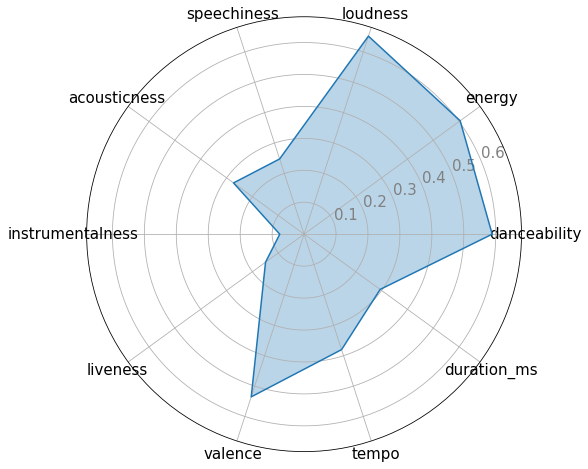

In [ ]:
import matplotlib.pyplot as plt
import math
# tamaño del gráfico
fig=plt.figure(figsize=(12,8))

# Convertimos el nombre de las columnas en una lista
categories=list(music_feature.columns)
# número de categorías
N=len(categories)

# crear una lista con el valor promedio de las características
value=list(music_feature.mean())

# debemos repetir el primer valor para que el cículo "se cierre"
value+=value[:1]
# calculamos el ángulo de cada categoría dentro del círculo
angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

# Graficamos
plt.polar(angles, value)
plt.fill(angles,value,alpha=0.3)

# Podríamos agregar un título con:  plt.title('Perfil de gustos', size=35)

plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)
plt.show()